# Introduction

Our software implements automatic differentiation (AD). Briefly, AD is a method of finding the derivatives of functions quickly and to machine precision. We will first describe general topics in computing that use differentiation, and then discuss why this approach (over symbolic or numerical differentiation) is especially useful.

## Uses for fast differentiation 
There is a broad range of applications for software that can perform fast differentiation. We list only a few below.
* **Physics and chemistry:** 
    Any simulation of a system with evolving vector fields or particles with individual trajectories likely needs to differentiate large sets of equations. These equations could govern velocities, forces, or other properties that are assigned to a single region of the vector field or a single particle. For example, chemists and physicists use molecular dynamics simulations to study chemical solutions or to conduct biophysical modelling. These simulations model each molecule in a solution, let them evolve over time, and see how interactions settle into equilibrium. They aid understanding in areas like protein conformation, DNA packing, or crystal deformations.


* **Deep neural networks:** 
    When deep neural networks are trained to compute some function, the training process requires a backpropagation of errors to move weights in directions that will minimize those errors. The backpropagation step involves calculating derivatives of errors with respect to weights, and in multi-layer networks, many calculations must be done iteratively to update the entire network. Therefore, deep neural networks, found extensively in machine learning, benefit greatly from well-implemented differentiation packages.
    
    
* **Optimization:** 
    While neural networks been given a lot of attention, they can be considered a subset of more general optimization problems. These include optimizing geometries for engineering projects, developing protocols for resource usage at large companies, or improving a policy in reinforcement learning. Optimization is often done iteratively; small steps are taken in the direction of performance gradients. The scale of differentiation necessary depends on the situation (reflected in input dimensionality or number of functions) but AD can easily be applied to many of these cases.

## Why automatic differentiation?
The major alternatives to AD are symbolic and numeric differentiation. Symbolic differentiation maintains full symbolic representations of function derivatives. These can be convoluted and unwieldy, especially when we need to store large numbers of them. Overall, speed is an issue for symbolic differentiation. Numeric differentiation, on the other hand, suffers from accuracy. Its implementations usually depend on linearizing a function around the point at which to calculate a derivative. These linearizations suffer from rounding errors. Both symbolic and numeric differentiation perform worse and worse in their respective weaknesses as the order of derivatives increases.

For the examples in the previous section, we may require derivatives for thousands or millions of functions as quickly as possible. Thus, symbolic differentiation is at a disadvantage. At the same time, small systematic errors can propagate and impact the performance of a system. In the case of a molecular dynamics simulation, for instance, the output of the simulation will be a set of averaged quantities over all particles in the system. These outputs could be sensitive to the precision in derivatives for force or velocity equations, especially if calculations are consistently off for every particle. Numeric differentiation, then, may interfere with simulation results.

AD is both fast and precise. Consequently, it is often the best choice in our given scenarios to carry out differentiation on extensive sets of functions.

## The use of multithreading and its justification
Our project extension was to implement our AD package with an option to use multithreading. 
Multithreading allows us to parallelize separable tasks during execution. In other words, 
computations that do not depend on each other can be run simultaneously to speed up AD calculations. 
This allows our software to be used on larger sets of vector-valued functions, such as ones that would 
be found in common applications like machine learning. This also allows us to calculate the derivative of a single function with multiple seed values very 
quickly, which would be used for applications like Newton's method. We cover what multithreading is and how we use 
it in the Background section, and we present our full multithreading capabilities in the Extension section.

# Background
Automatic differentiation decomposes a function into its elementary constituents. It strings them together into a graph, which can be traced through to calculate derivatives using the chain rule. Each node in the graph only depends on its associated edges and the values of adjacent nodes, obviating the need to store symbolic representations of the entire function's derivative. We show an example below.
### Example: Automatic differentiation using a table
We can demonstrate the automatic differentiation process on the function 
$$
f(\mathbf{x}) = e^{\sin(x_1+x_2)}-e^{\cos(x_1-x_2)}
$$

First, we construct a graph comprised of only elementary functions (e.g. $+,\; -,\; *,\; /,\; \sin(x),\; \cos(x),\; e^x$).

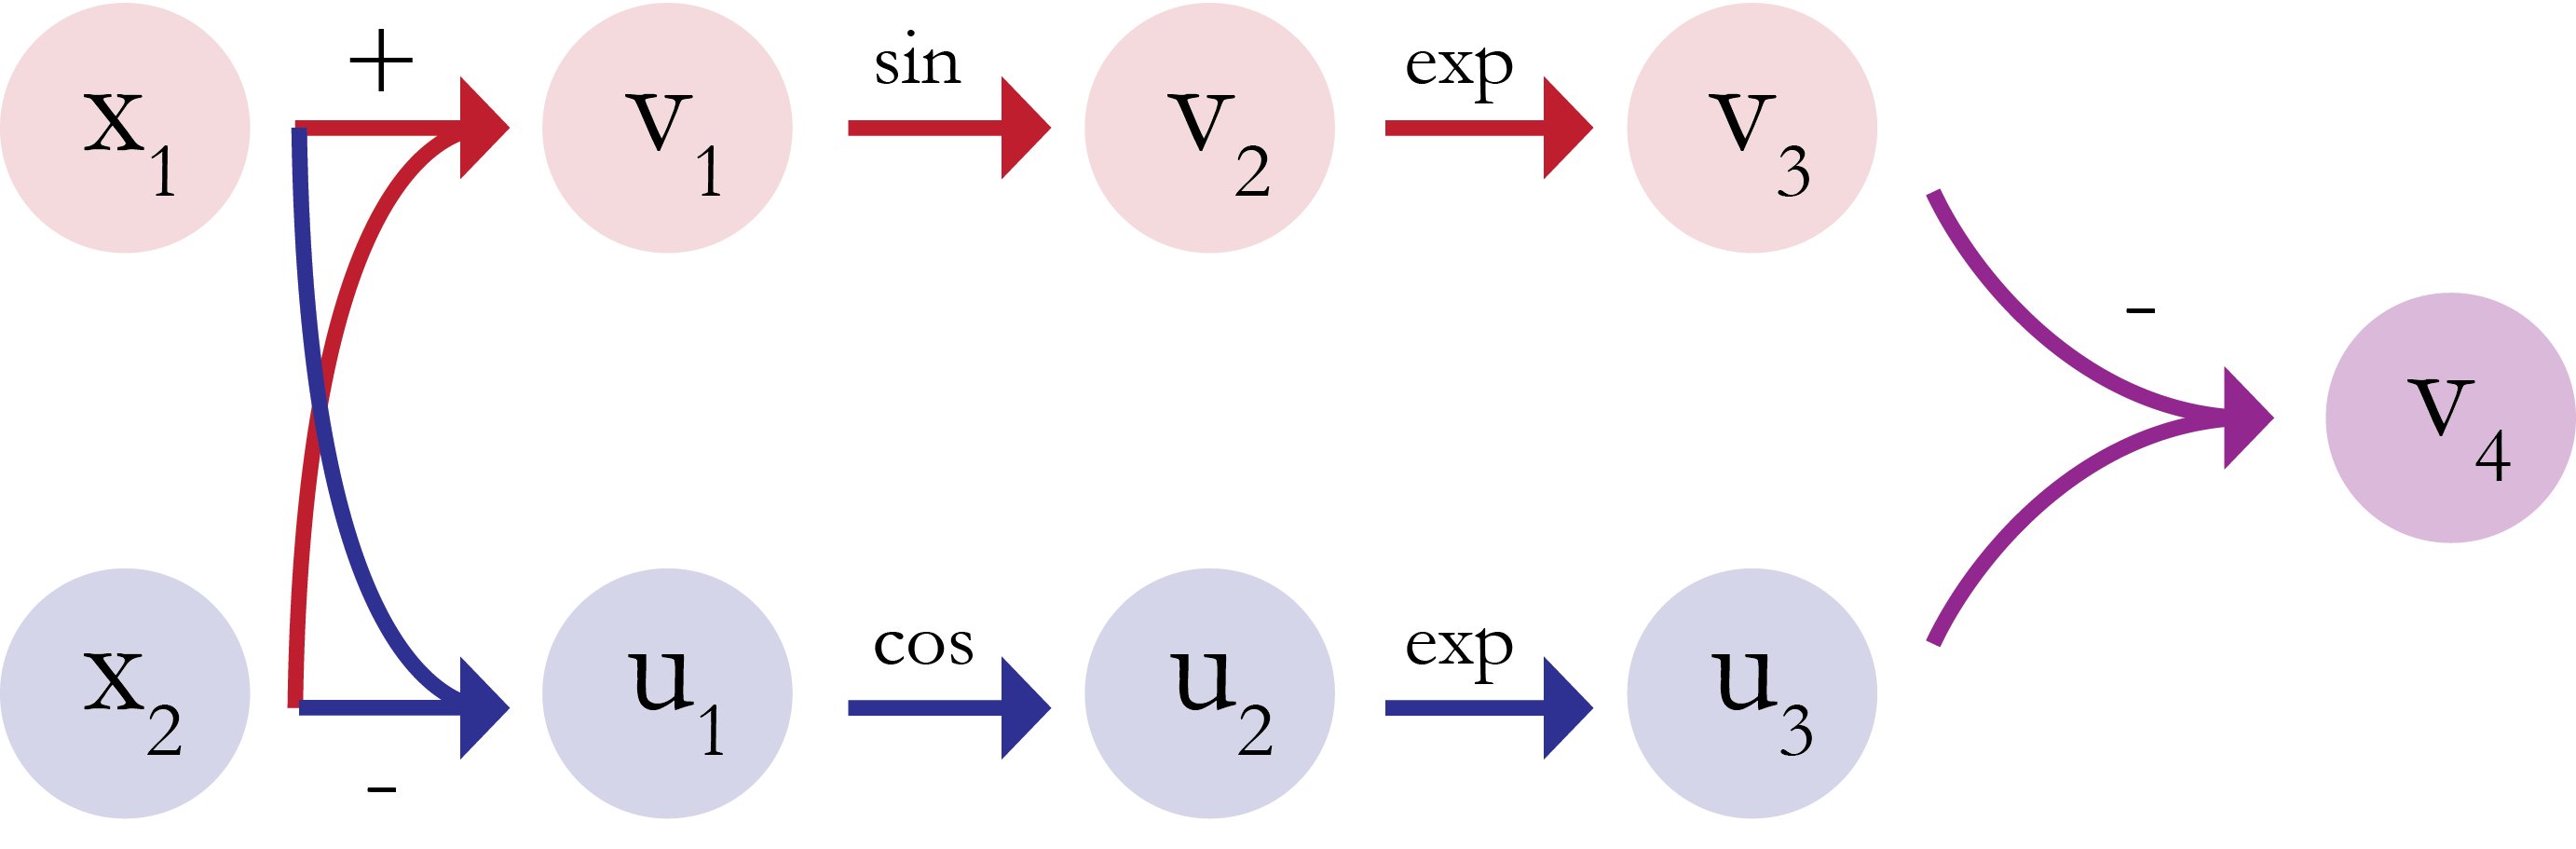

In [2]:
from IPython.display import Image, display
display(Image(filename='ADGraph.png', embed=True,width=500))

Next, we evaluate each node for its value, elementary symbolic derivative, and derivative value. At every step, the symbolic derivative is multiplied by the previous derivative value if needed. This is how the chain rule is implemented. We choose arbitrary points to evaluate the derivative at: $\mathbf{x}=(\pi/2,\pi/2)$ and two seed vectors $\mathbf{\dot{x}_a}=(1,0)$ and $\mathbf{\dot{x}_b}=(0,1)$. The seed vectors indicate the direction in which we want the derivative: a seed vector of $\mathbf{\dot{x}}=(1,0)$ returns the function's partial derivative with respect to the first dimension; $\mathbf{\dot{x}}=(0,1)$ is with respect to the second. A seed vector of $\mathbf{\dot{x}}=(1,1)$ would return the change in the function in the direction of vector $(1,1)$.

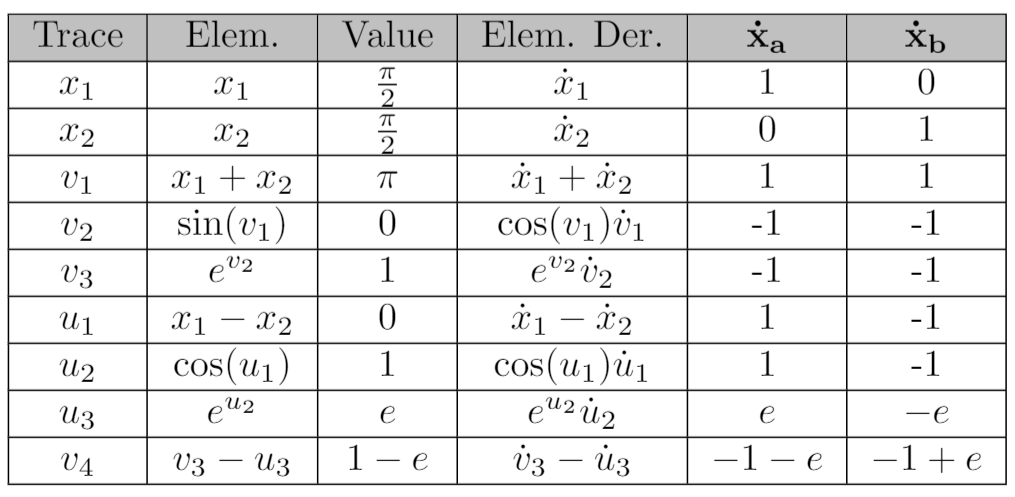

In [ ]:
display(Image(filename='ADTable.png',embed=True,width=600))

From the last row, we have derivatives evaluated to be $-1-e$ for $\mathbf{\dot{x}_a}=(1,0)$ and $-1+e$ for $\mathbf{\dot{x}_b}=(0,1)$. In this case, our seed vectors were chosen to return partial derivatives with respect to each input variable. Hence,
$$
\frac{\partial f}{\partial x_1} = -1-e
$$
$$
\frac{\partial f}{\partial x_2} = -1+e
$$

## Multithreading

Multithreading is a way of splitting workloads so that work can be performed in a parallel versus sequential way. Though multithreading is commonly used to achive code speedup, it is not well suited to all applications. For example, if in a for loop each iteration modifies or uses a result from the previous iteration, then the for loop may not be parallelizable since the use case is inherent sequential. 

However, this particular library has multiple features that are well-suited for multithreading. 
In particular, this library supports differentiation of multiple vector functions and differentiation of a single function using multiple seed values. 
Each of the vector functions can be differentiated independently, as well as the derivative of a function 
at different seed values. This would imply that each of these independent functions can be run by a 
single thread; spawning multiple threads should allow us to achieve a speedup by a factor of $n$, where
$n$ is the number of cores available. 

We use provide two multithreaded implementations of autodifferentiation.

The first uses OpenMP. This library can be compiled with OpenMP by running `./config.sh --thread` at the project root. 
OpenMP will then be linked by the g++. Using OpenMP requires that OpenMP be installed, though it does come with most compilers.

We also implement a multithreaded AutoDiffer with the `std::thread` interface, which is part of the C++11 concurrency
API. See Extension documentation for detailed examples as well as performance analysis comparing 
the two options.

# How To Use This Package

***

## Install

To build this project, clone the repo and run `bash config.sh` in the top level. This will build, install, and run the unit tests. 

## Examples 

There are two ways to interact with the AutoDiffer library. The first (and strongly recommend) option is to use the AutoDiffer
object, which parses the functions that the user inputs as strings. The second is through manual use of the ADNode & ADValue objects. We 
present a simple demo of each below. Both examples can be found in the `examples/` directory under
`example_autodiffer_scalar.cpp` and `example_adnode_scalar.cpp` respectively.

### AutoDiffer

The main class exposed by the package is `AutoDiffer`. This is the simplest way to interact with our library. 

After instantiation, seeds and variable names will be set with the `.SetSeed()` method. The inputs to `.SetSeed()` are 

1. the list of variable names 
2. the set of starting values
3. the seed indicating the direction in which we would like to find derivatives.

In this example, we want to evaluate the function and the derivative of $f(x) = (x+5)^3$ at $x=7$.
```
AutoDiffer<double> ad;
ad.SetSeed("x",/*value=*/7., /*dval=*/1.);
```
Equations are input to the `.Derive()` method, which returns a `Status` object (used for error-checking), and the differentiation result,
which is stored in an ADValue object. The ADValue object contains a value, which can be accessed with the `.val()`
interface, and a vector of derivatives which can be accessed by the `.dval(i)` interface, where `i` is the 
index of the desired derivative (e.g., the partial of $f$ with respect to the $i^{th}$ seed variable times the $i^{th}$ seed initial value). 
Since this is a scalar function, we can access the derivative with `.dval(0)`.
```
std::pair<Status, ADValue<double>> res; // declaration of variable that will contain AutoDiffer's output
res = ad.Derive("((x+5)^3)");
```
Now, `res` should have
```
res.first.code == ReturnCode::success;
res.second.val() == 1728;
res.second.dval(0) == 432;
```

This exact example can be found in `examples/example_autodiffer_scalar.cpp`.
See `examples/example_autodiffer_scalar2.cpp` for a more complicated function. The examples can be built with `make` in the examples directory. 
Then run with `./example_autodiffer_scalar` or `./example_autodiffer_scalar2` respectively.

### ADValue and ADNode usage

It is possible for the user to directly use the ADValue and ADNode objects to create functions. The ADNode objects
are used to represent elementary operations and combine multiple ADValue objects. Let's dive right in to an example.
Imagine we want to differentiate the function $f(x) = \cos(x+5)$ at $x=3$. First, we need to create two ADValue objects.
ADValues are constructed with an initial value and a single seed (scalar case) or std::vector of seeds (vector case).
Since this is the scalar case, we will just initialize a single seed value.

A note to the user: Mathematically invalid functions should return a `NaN` in the value. Please try to catch the `NaN`, 
since returning a `NaN` does not return an error. If the value is `NaN`, then the derivative should likely also not be used.
Examples of when a `NaN` would be returned is dividing by 0 or calling `arcsin` on a value that's out of the domain.
```
// The ADValue object representing x.
ADValue<double> x(/*value=*/3, /*seed=*/1);

// The ADValue object representing the constant 5. 
ADValue<double> v1(/*value=*/5, /*seed=*/0);
```
Notice that constant values need to have the seed value initialized to zero (because they have a zero derivative).
Next, we create an ADNode object associated with the addition operation on the two variables.
```
ADNode<double> node1(x, v1, Operation::addition);
```
In this case, the constructor for the ADNode object takes two ADValues and and an operation because it is a binary operation.
As we will see when we call cosine, the constructor is overloaded to take a single ADValue in the case of unary operations.
Calling `Evaluate()` on our newly created ADNode object returns the ADValue containing the result.
```
ADValue<double> x2 = node1.Evaluate();
```
Now we are ready to create the next ADNode.
```
ADNode<double> node2(x2, Operation::cos);
```
Notice that in this case, since cosine is a unary operation, the constructor can just be called with a
single ADValue. 
Finally, we extract the final value using the evaluate function:
```
ADValue<double> final = node2.Evaluate();
```
We can check that this ADValue object has the correct values of the function and derivative of $\cos(x+5)$ at x=3.
```
final.val() == cos(8);
final.dval(0) == -sin(8);
```
This exact example can be found in `examples/example_adnode_scalar.cpp`.
The example can be built with `make` in the examples directory. 
Then run with `./example_adnode_scalar`.

---

### Further examples

Many more examples can be found in the examples directory. We describe the basic demos below, but see [examples README](https://github.com/79-99/cs107-FinalProject/blob/master/examples/README.md)
for a more exhaustive set. 

```
|---examples
|   |---example_adnode_scalar.cpp            // Simple usage of ADNode and Value objects to derive scalar function.
    |---example_autodiffer_jacobian.cpp      // Demonstration of how to get jacobian of 3 vector functions each with 2 variables.
    |---example_autodiffer_scalar.cpp        // Simple usage of AutoDiffer on scalar function.
    |---example_autodiffer_scalar2.cpp       // More complicated scalar function with AutoDiffer.
    |---example_autodiffer_vector.cpp        // Vector function with AutoDiffer.
    |---Makefile
    |---live_demo
    |   |---example_live_demo.cpp            // Basic example used for live demo in video.
        |---Makefile
    |---multithreading
    |   |---example_multiple_functions.cpp   // Simplest multi-threaded example using std::threads.
        |---Makefile
        |---benchmark
        |   |---benchmark.sh                 // Shell script to run many openmp and std thread examples.
            |---example_opennmp.cpp          // Openmp multithreaded example.
            |---example_std_thread.cpp       // Same as above but with std::thread.
            |---Makefile
            |---data
            |   |---openmp_case_A.txt        // Case A data for Openmp created by benchmark.sh.
                |---openmp_case_B.txt        // Case B data for Openmp created by benchmark.sh.
                |---std_case_A.txt           // Case A data for std::thread created by benchmark.sh.
                |---std_case_B.txt           // Case B data for std::thread created by benchmark.sh.
                |---data.ipynb               // Jupyter notebook to plot data.
```


## Base examples.

Each of these examples live in the top level `examples/` directory. Running `make`
in this directory will build all five of the following examples. Each can be ran with
their respective name after make finishes (e.g., `./example_autodiffer_jacobian`).
Each of these examples prints to the terminal the expected and AutoDiffer results.
Examples 1,3,4 are one scalar valued functions. Example 2 is 3 functions of 2 variables.
Example 5 is one function of 2 variables.

1. `example_adnode_scalar.cpp`
2. `example_autodiffer_jacobian.cpp`
3. `example_autodiffer_scalar.cpp`
4. `example_autodiffer_scalar2.cpp`
5. `example_autodiffer_vector.cpp` 

## Multithreading examples.

### Simplest multithreaded example.
Based on our multithreading extension, we present a number of further examples. The first is
`multithreading/example_multiple_functions.cpp`. This demonstrates the simplest multithreading
use case which is passing a vector of functions into the `DeriveStdThread` call. This example 
can be built by running `make` in `examples/multithreading`, and is run with 
`./example_multiple_functions`, which should provide an output similar to the one below:

```
Multithreaded time (microseconds): 4308
Single threaded time (microseconds): 16392
```

For more extensive multithreading examples, see [examples README](https://github.com/79-99/cs107-FinalProject/blob/master/examples/README.md).

***

### Formatting inputs
For simplicity, we restrict how inputs should be formatted. 

We expect functions to be passed into the `AutoDiffer` parser as strings. 

Variables should contain alpha characters. Variables that are multiplied together should be denoted with an asterisk, such as: `x*y` vs. `xy`. 
Variables multiplied by constants should also be multiplied with an asterisk. 
`3x` may be interpreted as a single variable instead of a variable multiplied with a constant. 
Similarly, two variables multiplied together without asterisk separation will be read as a single variable. 

Because of how function parsing is implemented, a set of parentheses should only contain one operator that is not contained within another set of parentheses. This implies that `(2*((x+y)+z))` is a valid function while `(2*(x+y+z))` is not, even though addition is commutative.
Functions such as sin, cos, tan, and exp are also considered operators so should be wrapped with parentheses. `sin(x)` is not a valid eqn; `(sin(x))` is a valid eqn.

Please enclose the entire function in a set of parentheses.

Some examples of appropriate equation formatting:
```
"(x/3)"
"(tan(x/3))"
"(exp((sin((2*x)/3))/(x^2)))"
```

Variables cannot be of the form "x" + "n" where n is some integer number. Variables such as x0, x1, x2, etc. are used internally and name clashes will result in incorrect behavior.

We support the following operations, and include the simplest syntax that can be used:

1. addition -- `"(x+y)"`
2. subtraction -- `"(x-y)"`
3. multiplication -- `"(x*y)"`
4. division -- `"(x/y)"`
5. power -- `"(x^y)"`
6. sin -- `"(sin(x))"`
7. cos -- `"(cos(x))"`
8. tan -- `"(tan(x))"`
9. exp -- `"(exp(x))"`
10. arcsin -- `"(arcsin(x))"`
11. arccos -- `"(arccos(x))"`
12. arctan -- `"(arctan(x))"`
13. sinh -- `"(sinh(x))"`
14. cosh -- `"(cosh(x))"`
15. tanh -- `"(tanh(x))"`
16. logistic -- `"(logistic(x))"`
17. log -- `"(log_3.1135_(x))" `
18. sqrt -- `"(sqrt(x))"`
19. negation -- `"(-x)"`

Note that (-3+x) will not work even though -3 is also considered to be a double. In this case, the parser will
read the - sign as being a negation, so the correct formatting would be `"((-3)+x)"`. Also note that the
parser *is* whitespace sensitive. So please omit any white space from equations.

***

## Additional Imports

1. CMake should be installed following these instructions: https://cmake.org/install/
2. If g++ is not present, it should be installed. Google search for instructions per operating system.
3. If Openmp is not present it should be installed. See https://www.openmp.org/resources/openmp-compilers-tools/

All other external dependencies are handled by the library. 

# Software Organization and Package Access

## What will the directory structure look like?

We built our directory from the Skeleton project provided by Dr. Kirby.

```
root 
|---3PL                              # This is for third party code. Do not edit.
|---AutoDiffer                       # This is where the AD library exists.
|   |---build
    |---CMakeFiles
    |---core
    |   |---src
        |---tests
        |   |---src                                    # This directory includes all our tests.
            |   |---CMakeLists.txt
                |---test_ADNode.cpp
                |---test_ADValue.cpp
                |---test_AutoDiffer_correctness.cpp
                |---test_AutoDiffer_invalid.cpp
                |---test_AutoDiffer_multithread.cpp
                |---test_AutoDiffer_vector.cpp
                |---test_Parser.cpp
                |---test_vars.h
            |---CMakeLists.txt
            |---test_main.cpp
        |---CMakeLists.txt
    |---include
    |   |---ADNode.hpp               # These are the implementation files.
        |---ADValue.hpp
        |---AutoDiffer.hpp
        |---Parser.hpp
    |---install
    |---CMakeLists.txt
    |---config.sh                    # This is the script to run tests for AutoDiffer.
    |---coverage.sh                  # This is the script to run coverage for AutoDiffer.
|---docs
|   |---milestone1.ipynb
    |---milestone2_progress.txt
    |---milestone2.ipynb
    |---documentation.ipynb
|---examples                         # Many examples, see examples/README.md for details.
|---install
```
***

## What external libraries do you plan on including? What is their basic functionality? What about internal classes and methods?

We use the `gtest` external library to execute our unit tests. See https://github.com/google/googletest.

Internally, we have classes for the `ADNode`, `ADValue`, `AutoDiffer`, and `Parser`. More information for their uses and member functions can be found in the implementation section of the documentation. 
We generally recommend that the user will only directly interact with the `AutoDiffer` object and should only access the `AutoDiffer` header file. 
***

## Where will your test suite live? Will you use TravisCI or CodeCov?

Tests will live in their own folder underneath the project root directory. This project will use both TravisCI and CodeCov. TravisCI will be used to run these tests to ensure that the current code iteration is buildable and correct. CodeCov will be used to ensure that the entire library is rigorously unit-tested. We use `gtest` to run unit tests. 

Broadly speaking, we have three types of testing. 

1. Unit tests - Used to ensure each class works in isolation. 
2. Integration tests - Used to ensure that the end to end flow of the AutoDiffer works.
2. Performance tests - Benchmarking to analyze performance of single vs mulithreaded AutoDiffer. See Extension documentation for more details.

***

## How will you distribute and package your software? 

This automatic differentiation package is located at https://github.com/79-99/cs107-FinalProject. 

To use: 

1. Clone the git repository.
2. Run `bash config.sh` in the top level directory (to compile with Openmp run `bash config.sh --thread`).
3. Explore the `examples/` directory to understand usage.
4. Include `AutoDiffer.hpp` and you are all set! Since this is a header only library, no linking is necessary (see examples for demo Makefiles). 


# Implementation

---

__*What are the core data structures?*__

The core data structures are managed by the ADValue, Parser and AutoDiffer classes. 

__`ADValue`__

1. `v` : This represents the value of the function at the given point.
2. `dvs` : This represents a vector of derivatives for each value that was seeded. This corresponds to the 
partial derivative of the function with respect to that variable.


__`Parser`__

1. `values_` : This is a `std::unordered_map` (a hash table), that maps variable names (e.g., `x0, x1,...`) to their current values, which are encapsulated in
`ADValue` objects. As the parser makes its way through the equation, it checks to see if the variable is in this table, and returns an error if it is not.
2. `equation_`: This is a `std::string` passed to the parser upon construction. Each parser can only have one equation.
so in the case of multiple functions, multiple parsers are created. In our multithreading extension, each thread spins up a its own parser.

__`AutoDiffer`__

1. `seeds_` : This is a `std::vector` of `std::pair<std::string, ADValue>` objects. The user calls the `SetSeed` inteface to initialize a new element and emplace it
into the vector. When `Derive` is called, a `Parser` is created, and the seed vector is passed into the initialization of the `Parser` along with the actual equation. 



---

__*What classes will you implement?*__

Our implementation will be based on the following classes.

__`AutoDiffer`__ $-$ The outer class and also the public interface exposed by our library. The `AutoDiffer` is passed seeds and can be asked to return the derivative and function values of
one or more functions of one or more variables.

__`AutoDifferOpenMp`__ $-$ A derived class of `AutoDiffer` that implements multithreading via openmp. Part of the public interface.

__`AutoDifferStdThread`__ $-$ A derived class of `AutoDiffer` that implements multithreading via std::thread. Part of the public interface.

__`Parser`__ $-$ The class responsible for parsing the functions passed as strings into the `AutoDiffer`. Parsers are created when the `AutoDiffer` is called to compute the derivative of a function. 
Each function  is a string, and each elementary operation will be wrapped in a pair of parentheses. For example the function, $f(x,y) = xy+x^2$ maps to the following input `((x*y)+(x^2))`. 

__`ADNode`__ $-$ The class that represents a vertex in the computational graph. Contains two `ADValue` instances and an operation that describes how to combine them. 
Calling `Evaluate()` on a node runs the elementary operation on the two `ADValue`'s and returns an `ADValue`.
In the case of unary operations, the auxilary vertex is initialized to zero and ignored by the elementary operations.

__`ADValue`__ $-$ This is the general object representing values in the system and is mainly used by  `ADNode`. An `ADValue` is comprised of a value and a vector of derivative. 
All elementary functions are defined in this class. We overloaded the `==` and `!=` comparison operators on this class.

---
__*What method and name attributes will your classes have?*__

__`AutoDiffer`__ 

*Key Member functions*

1. `SetSeed(const std::string& variable, T value, T dval=1)` $-$ For scalar functions : Loads into `seeds_` the variable used in an equation and the seed value and derivative.
2. `SetSeedVector(const std::string& variable, T value, std::vector<T> dvals)` $-$ For vector functions : Loads into `seeds_` the variable used in an equation and the seed value and derivatives.
3. `Derive(std::string equation)` $-$ Spawns and calls `Run()` on a parser constructed with the input equation. 
This function returns a `std::pair<Status, ADValue<T>>`. If the derive completes successfully, then the Status will 
have `code == ReturnCode::success` and the `ADValue` contains the result. If there is an error in the parsing
the status will have `code == ReturnCode::parse_error` and will contain a message with the appropriate error.
4. `Derive(std::vector<std::string> equations)` $-$ Same as 3, but with a vector of functions. Returns a vector of status and ADValue pairs.
5. `Derive(std::string equation, std::vector<std::vector<std::pair<std::string, ADValue<T>>>>)` $-$ Runs derive on a single
function, but with many different seeds that are passed in (2d vector is passed as second param).


*Key Class variables*

1. `std::vector<std::pair<std::string, ADValue<T>>> seeds_` $-$ Collection of variables to be used and their seed values (including value and partial derivatives).


__`AutoDifferOpenMp : (derived from AutoDiffer)`__ 

*Key Member functions*

1. `DeriveOpenMp(std::vector<std::string> equations)` $-$ Same as 4 from AutoDiffer, but with openmp multithreading supported.
2. `DeriveOpenMp(std::string equation, std::vector<std::vector<std::pair<std::string, ADValue<T>>>>)` $-$ Same as 5 from AutoDiffer, but with openmp multithreading supported.

__`AutoDifferStdThread : (derived from AutoDiffer)`__ 

*Key Member functions*

1. `DeriveStdThread(std::vector<std::string> equations)` $-$ Same as 4 from AutoDiffer, but with std::thread multithreading supported.
2. `DeriveStdThread(std::string equation, std::vector<std::vector<std::pair<std::string, ADValue<T>>>>)` $-$ Same as 5 from AutoDiffer, but with std::thread multithreading supported.

__`Parser`__

*Member functions*

1. `Parser(std::string equation)` $-$ Constructor which saves the input equation.
2. `Status Init(std::vector<std::pair<std::string, ADValue<T>>> seed_values)` $-$ Loads the variables and their seed values into 
`values_`. Sets the cursor used for parsing; this method throws a parse error if there are unbalanced 
parantheses or if there are no left parentheses.
3. `Status Next()` $-$ Function in which most of the work is done. Considers the part of the equation within a single parenthesis. 
Looks for operators including `+,-,*,/,^`, as well as special operators such as `sin, cos, tan, exp`, etc. 
If the function is formatted correctly, parses the equation within the parenthesis to create an `ADNode`, 
which is then evaluated. A variable name is mapped to this `ADNode`, and then name and `ADNode` are stored 
in the values_ map. This method then replaces then parenthesis and the evaluated expression inside with 
that new `ADNode` name. 
4. `std::pair<Status,ADValue<T>> Run()` $-$ Calls `Next()` either until the entire equation has been evaluated or `Next()` returns an non-success error code.

*Class variables*

1. `std::unordered_map<std::string, ADValue<T>> values_` $-$ Stores the names of input variables and their seed values, as well as generated `ADValue`s and their names. This implies that after an expression within a single parenthesis is run, its resulting name and `ADValue` will be stored for later use. 
2. `int left_cursor_, right_cursor_` $-$ Contains indices of current parentheses within which to parse. Set by `SetCursor()`, a method not directly callable by the user.
3. `int v_idx_` $-$ Names for intermediate variables are generated, such as x0, x1, x2, etc. Input variables should not be of the format `xn`, where n is any integer. 

__`ADNode`__ 

*Member functions*

1. `Evaluate()` $-$ Returns an `ADValue` whose v and dv are the result of combining the two member `ADValue`s with the correct operator.

*Class Variables*

1. `ADValue<T> self_vertex_, aux_vartex_` $-$ Two `ADValue`s to operate on (in unary case, the `aux_vertex_` is igrored).
2. `Operation op_` $-$ Variable to describe how to operate on the two `ADValue`s. 

__`ADValue`__ 

*Member functions*

1. `ADValue` $-$ Initialize value and derivative.
2. Operator functions (not listed). Returns an `ADValue`. See `Formatting inputs` for list of supported functions.
3. Getters (`val()`, `dval()`) for the value and derivatives.
4. `operator==` $-$ overloaded equality operator. Returns true if value and derivative values all match.
4. `operator!=` $-$ overloaded not equa operator. Returns opposite of `==`.

*Class variables*

1. `T v` $-$ Current value.
2. `std::vector<T> dvs` $-$ Current derivative.
---

__*What external dependencies will you rely on?*__

1. C++ Standard Template Library (c++14).
2. GoogleTest (`gtest`)
3. Make/Cmake.
4. g++
5. OpenMP

---

__*How will you deal with elementary functions like sin, sqrt, log, and exp?*__

The actual calculations of the elementary functions will be done using the `cmath` library.
 From an implementation standpoint, each elementary operation will be have a public inteface on the `ADValue` 
 object so that when the operations are done, the correct derivative values are calculated and saved. 

# Extension: Multithreading.

Multithreading is a way of splitting workloads so that work can be performed in a parallel versus sequential way. 
Though multithreading is commonly used to achive code speedup, it is not well suited to all applications. 
For example, if in a for loop each iteration modifies or uses a result from the previous iteration, then the for 
loop may not be parallelizable since the use case is inherent sequential.

However, this particular library has multiple features that are well-suited for multithreading. 
In particular, this library supports differentiation of vector functions and differentiation of a 
single function using multiple seed values. Each of the vector functions can be differentiated independently, as well as the derivative of a function at different seed values. This would imply that each of these independent functions can be run by a single thread; spawning multiple threads should allow us to achieve a speedup that goes like nn, where nn is the number of cores available.

We support two different multithreading options.
 
1. OpenMP
2. std::thread (c++11 concurrency API).

We found that each method worked well under different circumstances, which we analyze through
the use of the following examples.

### Base example.
The first is
`multithreading/example_multiple_functions.cpp`. This demonstrates the simplest multithreading
use case which is passing a vector of functions into the `DeriveStdThread` call. This example 
can be built by running `make` in `examples/multithreading`, and is run with 
`./example_multiple_functions`, which should provide an output similar to the one below:

```
Multithreaded time (microseconds): 4308
Single threaded time (microseconds): 16392
```

### Benchmark examples.
In the `examples/multithreading/benchmark/` directory, there are two more examples:

1. `example_openmp.cpp`
2. `example_std_thread.cpp`

which demonstrate the OpenMP and std::thread implementations of multithreading respectively.
These can be built by running `make` in `examples/multithreading/benchmark/`. 
Following the make, we recommend running `bash benchmark.sh` to collect data for your machine.
This will test a number of combinations of many equations and many ops per equation for both
openmp and std::thread. Note that you will need OpenMP installed in order to run the 
benchmarking. The compiler flags will take care of the rest. The output from the benchmarking script
should look like:

```
Collecting data for std::thread Case A .................... done!
Collecting data for std::thread Case B ..................... done!
Collecting data for openmp Case A .................... done!
Collecting data for openmp Case B ..................... done!
Data written to data/ directory!
```

Data is written to data/ and in the jupyter notebook [data.ipynb](https://github.com/79-99/cs107-FinalProject/blob/master/examples/multithreading/benchmark/data/data.ipynb) has
functions to plot the data that was generated. 

We collect data for two broad cases:

1. Case A: Large equations (in number of ops), but relatively few of them.
2. Case B: Small equations, but many of them.

Specifically we collect the following data:

1. Case A: Runtime for i in range 1, 2, ..., 20 equations, where each equation has 1500 operations.
1. Case B: Runtime for i in range 1, 1000, 2000, ..., 20000 equations, where each equation has 5 operations.

We collect this data for std::thread (which spins up a new thread for each equation) and
for openmp (which we default to six threads and uses thread pooling). We observe the following tradeoff between the 
multithreading options:

#### std::thread

1. Pros:
- Runtimes are consistently about 4x faster that single threaded version when there are relatively
few functions (Case A). 
- Outperforms openmp when there are few equations that each have a ton of operations (Case A).
- Also has the benefit of not needing a special compiler to run.
- Runtimes appear to be more consistent.

2. Cons:
- In the case where there are many functions, but each function is relatively small (Case B),
std::threads suffer. This is because a new thread is created for each function and
as a result the thread creation overhead overwhelms the performance improvement.

This is represented in the following images.

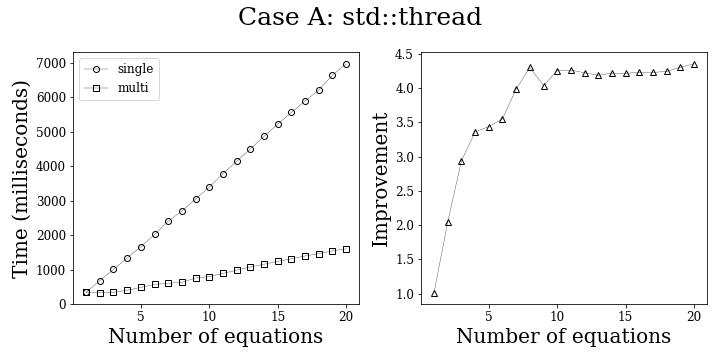

In [6]:
display(Image(filename='caseA_std.png',embed=True,width=600))

On the left plot we see the timings for single and multithreaded versions of the 
derivation. The right plot shows the ratio of single / multi, which can be 
interpreted as the speedup provided from the multithreading.
We see that for case A, std::thread has very consistent performance at about 4x. This was run
on a 1.4 GHz Quad-Core Intel Core i5, so 4x speedup is expected.

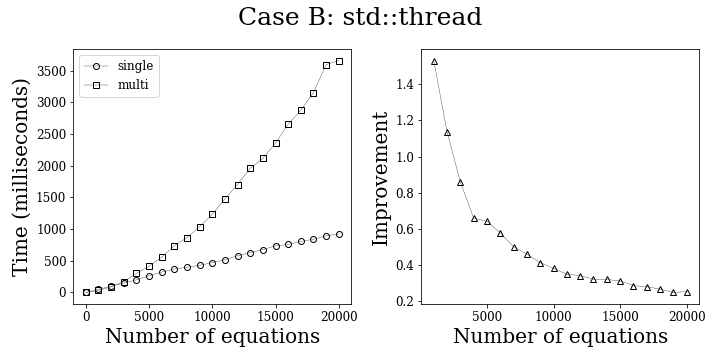

In [5]:
display(Image(filename='caseB_std.png',embed=True,width=600))

We see that for Case B, the std thread implementation is actually doing *worse* 
than the single threaded version (emphasized by the right plot approaching 0). The 
reason it does worse is because the overhead of spinning up and tearing down so many threads overwhelms 
the performance improvement from the parallelization. When benchmarking, it is important to take into 
account the fraction of time spent doing something; since the equations in Case B are so small, 
a much larger fraction of the time is spent in overhead vs. doing the real work of differentiating the equation.

#### OpenMP
1. Pros:
- Sees improvement for both Case A (about 3x) and Case B (about 4x). 
- Outperforms std::thread when there are many equations that each have a few of operations (Case B).

2. Cons:
- Requires a special compilation phase and adds an additional external dependency.
- Has higher variance in performance for Case A.

This is represented in the following images.

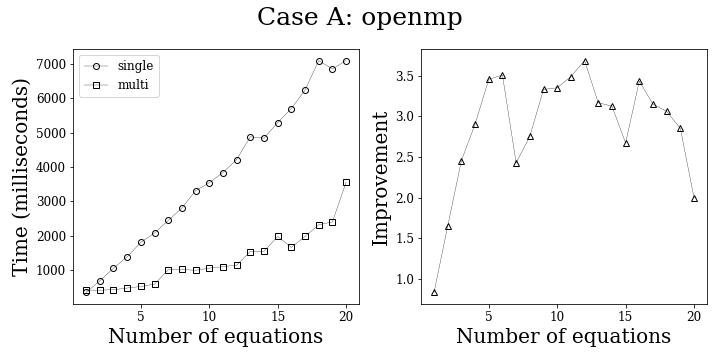

In [4]:
display(Image(filename='caseA_openmp.png',embed=True,width=600))

For case A, we see that OpenMP is performing about 3x as well as single threaded. However there
is a lot of variance in the exact ratio, which is undesirable.

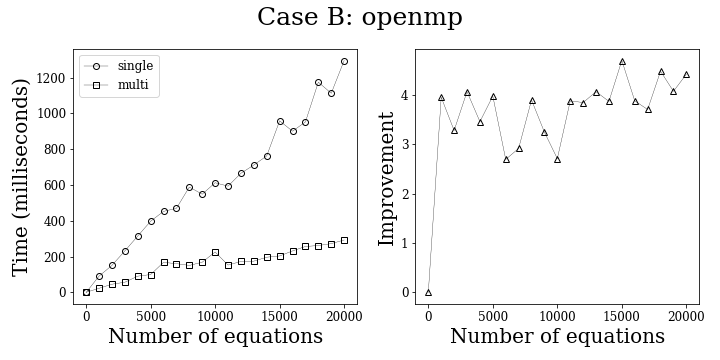

In [3]:
display(Image(filename='caseB_openmp.png',embed=True,width=600))

We see that for case B, the OpenMP version is outperforming the single thread 
by a consistent 4x. Again this makes sense given the hardware it was run on. The performance
here is so much better than std::thread because the OpenMP version reuses threads 
by maintaining thread pools that handle each iteration of the loop. Thus there is no
growth in the thread creation overhead, and OpenMP can max out the hardware. 

#### Conclusion.
Based on this analysis, we recommend the following for users who wish to use
multithreaded AutoDiffer. 

1. If the user can get OpenMP, then they should probably use this. OpenMP
provides the most consistent results for improvement across case A and case B (even 
though std thread performs marginally better in case A). This is the safest way to
achieve speedup.

2. If the user cannot access OpenMP, then they should consider the equations that they are
running on. If their set of equations seems closer to Case A (relatively few, e.g., < 100 total, and very large), then they should use 
std::thread AutoDiffer to see improvement. If their set of equations seems closer to 
Case B, then we encourage them to instead use the single threaded version of 
the AutoDiffer. 

-----

You can running these examples without calling the benchmarking script if you would like.
Both require command line arguments.

1. `./example_openmp num_equations num_ops num_threads`
- num_equations represents how many equations to create.
- num_ops represents how many ops per equation.
- num_threads set the open_mp number of threads used.
- `./example_openmp 100 100 5`
2. `example_std_thread.cpp`
- num_equations represents how many equations to create.
- num_ops represents how many ops per equation.
- `./example_std_thread 100 100`

The std::thread example doesn't need to specify number of threads because a new thread will be
created for each equation.

# Broader impact and inclusivity

* What are the potential broader impacts and implications of your software?


AD is a tool that can be applied in numerous branches of science and math. One of the most currently popular applications would be to speed up calculations for deep neural network training. Here we focus on issues in collecting or using large datasets, which is what the AD package would facilitate. 
Large datasets come with privacy, access, and data bias concerns. The first two relate to the datasets themselves. It is important to be aware, at every step of collection, of where data are coming from and how broadly available they are. If necessary, health data or other identifiable personal information must be properly anonymized. 
If privacy is a priority, then users of large datasets must respect the people providing their information. Otherwise, it would be preferable to have datasets be open-access for the sake of transparency in data science and research applications.

Another concern is that the larger NNs are, the more black-box-like they can become. Their inferences can be insidious depending on collection methods--for example, clinical data has historically been skewed toward white males. Even today, doctors are often less adept at recognizing symptoms of heart attacks in women because of how medical studies have prioritized studying disease presentation in males ("The Mounting Crisis in Women's Heart Health"). 
Due to data disparity, generalizations made by large NNs can perform poorly on female or minority populations. This means that even with the compute advantage that AD can provide, the data fed to a network must be carefully monitored to prevent harmful biases from data.

* How is your software inclusive to the broader community?

Our software is designed to be easy to use out-of-the-box. We have all of our code available on Github for anyone to clone and will look over contributions/pull requests as a team. We will take care to acknowledge our own implicit biases during review and try to reduce their effects on our decision-making.

We note that many people have reduced access to resources for learning C++, due to time constraints, language barriers, or overt or implicit discrimination in their educational system. 
To help mitigate such barriers, we include some resources: [Learn C++](https://www.learncpp.com/), [Cplusplus.com](https://www.cplusplus.com/), [edX resources](https://www.edx.org/learn/c-plus-plus). 
For non-native English speakers, there is a lot to be desired in terms of widely available educational resources for C++. Some steps in this direction, however, include subtitle options available for [Coursera](https://www.coursera.org/specializations/coding-for-everyone) classes or projects like [this one](https://github.com/akercheval/si) for Spanish-speaking students, which translates English keywords in Python or C++ to Spanish.

For broader support for underrepresented minorities in tech, [here](https://github.com/include-cpp/include) is a list of diversity and inclusion initiatives that specifically address issues in the C++ developers community.

Sources:

“The Mounting Crisis in Women's Heart Health.” Columbia University Department of Surgery, Columbia University Irving Medical Center, columbiasurgery.org/news/mounting-crisis-women-s-heart-health. 

# Future Features

1. __Improving parser flexibility.__ As of now, our parser is fairly brittle and depends on the user including the precise number of nested parentheses 
for the code to work. It also does not handle order of operations on its own and relies on the user to specify that with parentheses. Expanding
on the types of inputs our parser could handle would make the library easier to use.
2. __Reverse mode.__ Reverse mode is preferred in certain use cases. While forward mode has the user seed derivatives and specify input vectors, 
each input requires a pass through the graph. Reverse mode starts from the function output instead, and in that way can improve performance for 
some applications of autodifferentiation. It would be nice to have the option to use either, depending on on the application.
3. __Root-finding.__ Fast root-finding could be immediately applied in a number of fields. Optimization, for instance, could use root-finding algorithms
to minimize or maximize objective functions by finding zeros on the objective gradients. It would also be fairly straightforward to implement if we 
use Newton's method: we would calculate a Jacobian at each step until convergence.
4. __Consider using thread pooling mechanism.__  This could help improve efficiency
of our `std::thread` implementation in the case where there are thousands of functions. We could use this 
library for example https://github.com/vit-vit/CTPL/blob/master/ctpl.h.